In [381]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

In [382]:
data = pd.read_csv('data1.csv')
data.head()

,Местное время в Ростове-на-Дону,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,02.08.2023 12:00,28.2,748.0,NaN,NaN,54.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,02.08.2023 09:00,26.7,748.0,NaN,NaN,53.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02.08.2023 06:00,23.1,748.0,NaN,NaN,60.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Осадков нет,12.0,NaN,NaN,NaN,NaN
3,02.08.2023 03:00,23.5,748.0,NaN,NaN,55.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,02.08.2023 00:00,24.2,749.0,NaN,NaN,54.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Преобразовали тип данных в дату

In [383]:
data['Местное время в Ростове-на-Дону'] = data['Местное время в Ростове-на-Дону'].apply(lambda date: 
                                                                                        datetime.datetime.strptime(date, '%d.%m.%Y %H:%M'))
data['time'] = data['Местное время в Ростове-на-Дону'] 
data.index = data['time']
data = data.drop(['time', 'Местное время в Ростове-на-Дону'], axis=1)
data = data.sort_index()
data.head()

,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,6.1,744.2,751.0,NaN,87.0,"Ветер, дующий с юга",7.0,NaN,NaN,100%.,...,Клочья (часто чечевицеобразные) высококучевых ...,"Перисто-кучевые одни или перисто-кучевые, сопр...",10.0,4.1,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 03:00:00,7.0,743.4,750.2,NaN,87.0,"Ветер, дующий с юго-юго-запада",9.0,NaN,NaN,100%.,...,Клочья (часто чечевицеобразные) высококучевых ...,"Перисто-кучевые одни или перисто-кучевые, сопр...",10.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 06:00:00,7.1,742.8,749.6,NaN,95.0,"Ветер, дующий с юго-запада",11.0,15.0,15.0,100%.,...,Клочья (часто чечевицеобразные) высококучевых ...,"Перисто-кучевые одни или перисто-кучевые, сопр...",10.0,6.3,5.0,12.0,NaN,NaN,NaN,NaN
2010-01-01 09:00:00,4.8,744.4,751.2,NaN,95.0,"Ветер, дующий с запада",8.0,NaN,NaN,100%.,...,Клочья (часто чечевицеобразные) высококучевых ...,"Перисто-кучевые одни или перисто-кучевые, сопр...",2.5,4.1,5.0,12.0,NaN,NaN,NaN,NaN
2010-01-01 12:00:00,4.3,745.0,751.9,NaN,92.0,"Ветер, дующий с запада",4.0,NaN,NaN,"90 или более, но не 100%",...,"Высококучевые просвечивающие, расположенные на...",NaN,10.0,3.1,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='time'>

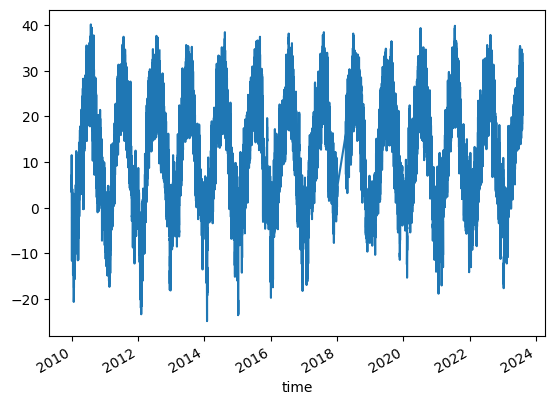

In [384]:
data['T'].plot()

Много столбоцов, в которых нет информации => оставляем только нужные:

In [385]:
# T - температура воздуха
# Po - Атмосферное давление ( в мм ртутного столба )
# U - Относительная влажность (в %)
# N - Общая облачость
# Tn - минимальная темп. воздуха за 12 часов
# Tx - максиммальная темп. воздуха за 12 часов
# RRR - кол-во выпавших осадков ( в мм )
data = data[['T', 'Po', 'U', 'N', 'Tn', 'Tx', 'RRR']]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38801 entries, 2010-01-01 00:00:00 to 2023-08-02 12:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       38776 non-null  float64
 1   Po      38754 non-null  float64
 2   U       38753 non-null  float64
 3   N       38390 non-null  object 
 4   Tn      6049 non-null   float64
 5   Tx      4837 non-null   float64
 6   RRR     8648 non-null   object 
dtypes: float64(5), object(2)
memory usage: 2.4+ MB


Не везде есть температура((( заменю позже

In [386]:
data.loc[data['T'].isnull()]

,T,Po,U,N,Tn,Tx,RRR
time,,,,,,,
2010-06-09 21:00:00,NaN,753.2,NaN,"10% или менее, но не 0",NaN,28.6,NaN
2010-06-12 09:00:00,NaN,754.8,NaN,"10% или менее, но не 0",20.1,NaN,NaN
2010-06-13 03:00:00,NaN,754.0,NaN,"10% или менее, но не 0",NaN,NaN,NaN
2010-08-25 09:00:00,NaN,752.5,NaN,"10% или менее, но не 0",15.7,NaN,NaN
2011-04-24 06:00:00,NaN,760.4,NaN,"10% или менее, но не 0",NaN,NaN,NaN
2011-06-02 03:00:00,NaN,755.2,NaN,20–30%.,NaN,NaN,NaN
2011-07-22 03:00:00,NaN,NaN,NaN,70 – 80%.,NaN,NaN,NaN
2011-08-20 15:00:00,NaN,NaN,NaN,"90 или более, но не 100%",NaN,NaN,NaN
2012-08-26 18:00:00,NaN,750.2,NaN,40%.,NaN,NaN,NaN


In [387]:
data['month'] = data.index.month
data['hour'] = data.index.hour
data.head()

,T,Po,U,N,Tn,Tx,RRR,month,hour
time,,,,,,,,,
2010-01-01 00:00:00,6.1,744.2,87.0,100%.,NaN,NaN,NaN,1,0
2010-01-01 03:00:00,7.0,743.4,87.0,100%.,NaN,NaN,NaN,1,3
2010-01-01 06:00:00,7.1,742.8,95.0,100%.,NaN,NaN,5.0,1,6
2010-01-01 09:00:00,4.8,744.4,95.0,100%.,4.8,NaN,5.0,1,9
2010-01-01 12:00:00,4.3,745.0,92.0,"90 или более, но не 100%",NaN,NaN,NaN,1,12


In [388]:
data['mean_month'] = list(map(dict(data.groupby(data.month)['T'].mean()).get, data['month'])) # среднемесячная температура
data.head()                         

,T,Po,U,N,Tn,Tx,RRR,month,hour,mean_month
time,,,,,,,,,,
2010-01-01 00:00:00,6.1,744.2,87.0,100%.,NaN,NaN,NaN,1,0,-2.572504
2010-01-01 03:00:00,7.0,743.4,87.0,100%.,NaN,NaN,NaN,1,3,-2.572504
2010-01-01 06:00:00,7.1,742.8,95.0,100%.,NaN,NaN,5.0,1,6,-2.572504
2010-01-01 09:00:00,4.8,744.4,95.0,100%.,4.8,NaN,5.0,1,9,-2.572504
2010-01-01 12:00:00,4.3,745.0,92.0,"90 или более, но не 100%",NaN,NaN,NaN,1,12,-2.572504


In [389]:
mean_hour = dict(data.groupby([data.month, data.hour])['T'].mean()) # средняя температура за час каждый месяц
data['mean_hour'] = None
for i in range(len(data)):
    month, hour = data.iloc[i]['month'], data.iloc[i]['hour']
    data.at[data.index[i], 'mean_hour'] = mean_hour[(month, hour)]
    
data.head()

,T,Po,U,N,Tn,Tx,RRR,month,hour,mean_month,mean_hour
time,,,,,,,,,,,
2010-01-01 00:00:00,6.1,744.2,87.0,100%.,NaN,NaN,NaN,1,0,-2.572504,-2.82928
2010-01-01 03:00:00,7.0,743.4,87.0,100%.,NaN,NaN,NaN,1,3,-2.572504,-3.173367
2010-01-01 06:00:00,7.1,742.8,95.0,100%.,NaN,NaN,5.0,1,6,-2.572504,-3.527681
2010-01-01 09:00:00,4.8,744.4,95.0,100%.,4.8,NaN,5.0,1,9,-2.572504,-3.542786
2010-01-01 12:00:00,4.3,745.0,92.0,"90 или более, но не 100%",NaN,NaN,NaN,1,12,-2.572504,-1.955721


Заполняем nan. 

In [390]:
data[['Tn', 'Tx', 'RRR', 'U', 'N', 'Po']] = data[['Tn', 'Tx', 'RRR', 'U', 'N', 'Po']].fillna(method='ffill')
data['T'] = data['T'].fillna(data['mean_hour'])
data = data.iloc[10:]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38791 entries, 2010-01-02 06:00:00 to 2023-08-02 12:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           38791 non-null  float64
 1   Po          38791 non-null  float64
 2   U           38791 non-null  float64
 3   N           38791 non-null  object 
 4   Tn          38791 non-null  float64
 5   Tx          38791 non-null  float64
 6   RRR         38791 non-null  object 
 7   month       38791 non-null  int32  
 8   hour        38791 non-null  int32  
 9   mean_month  38791 non-null  float64
 10  mean_hour   38791 non-null  object 
dtypes: float64(6), int32(2), object(3)
memory usage: 3.3+ MB


<Axes: xlabel='time'>

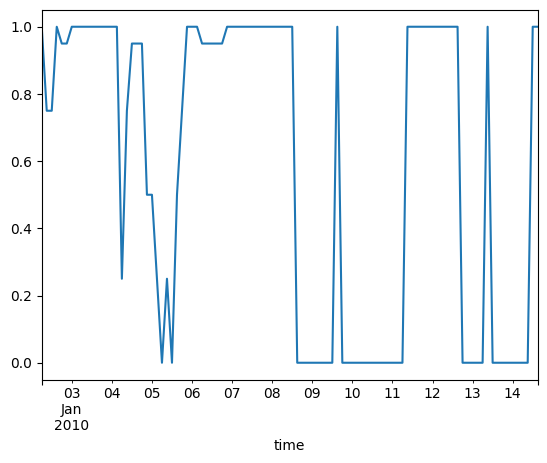

In [391]:
data['N'] = data['N'].replace({'20–30%.': 0.25, 'Облаков нет.': 0, '60%.': 0.6, '40%.':0.4,
       '10%  или менее, но не 0': 0.05, '70 – 80%.': 0.75, '50%.': 0.5, '100%.': 1,
       '90  или более, но не 100%': 0.95,
       'Небо не видно из-за тумана и/или других метеорологических явлений.': 0}) # Последнего значения не так много, поэтому просто припишу к 0
data.iloc[:100]['N'].plot()

<Axes: xlabel='time'>

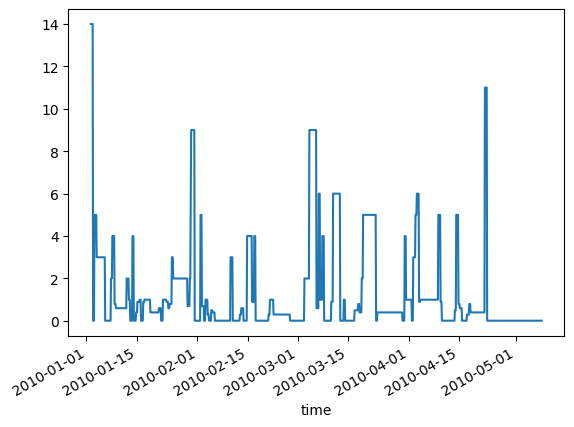

In [392]:
data['RRR'] = data['RRR'].replace({'Осадков нет': 0, 'Следы осадков': 0.01})
data['RRR'] = data['RRR'].astype(float)
data.iloc[:1000]['RRR'].plot() # интересно глянуть такой график в Питере)

Теперь нужно проставить lag'и по параметрам T, U, N, RRR. 

In [393]:
for i in range(1, 10):
        data[f"T_lag_{i}"] = data['T'].shift(i)
        data[f"U_lag_{i}"] = data['U'].shift(i)
        data[f"N_lag_{i}"] = data['N'].shift(i)
        data[f"RRR_lag_{i}"] = data['RRR'].shift(i)
        data[f"Po_lag_{i}"] = data['Po'].shift(i)
data = data.drop(['U', 'N', 'RRR', 'Po'], axis=1) #удаляем показатели в текущее время
data = data.iloc[10:]

In [394]:
data.head()

,T,Tn,Tx,month,hour,mean_month,mean_hour,T_lag_1,U_lag_1,N_lag_1,...,T_lag_8,U_lag_8,N_lag_8,RRR_lag_8,Po_lag_8,T_lag_9,U_lag_9,N_lag_9,RRR_lag_9,Po_lag_9
time,,,,,,,,,,,,,,,,,,,,,
2010-01-03 12:00:00,-0.6,2.1,11.9,1,12,-2.572504,-1.955721,2.1,94.0,1.0,...,10.4,86.0,0.75,14.00,737.6,8.4,88.0,0.75,14.00,738.4
2010-01-03 15:00:00,-2.1,2.1,11.9,1,15,-2.572504,-1.096526,-0.6,94.0,1.0,...,11.5,87.0,1.00,14.00,737.2,10.4,86.0,0.75,14.00,737.6
2010-01-03 18:00:00,-3.1,2.1,11.9,1,18,-2.572504,-1.958416,-2.1,84.0,1.0,...,11.3,87.0,0.95,14.00,737.4,11.5,87.0,1.00,14.00,737.2
2010-01-03 21:00:00,-3.5,2.1,5.0,1,21,-2.572504,-2.510697,-3.1,81.0,1.0,...,10.1,89.0,0.95,0.01,736.6,11.3,87.0,0.95,14.00,737.4
2010-01-04 00:00:00,-4.7,2.1,5.0,1,0,-2.572504,-2.82928,-3.5,85.0,1.0,...,8.9,97.0,1.00,0.01,736.6,10.1,89.0,0.95,0.01,736.6


Теперь пробуем обучать модель. Для начала при помощи линейной регрессии

Text(0.5, 1.0, 'Linear regression\n Mean absolute error 1.1672166693407313 degrees')

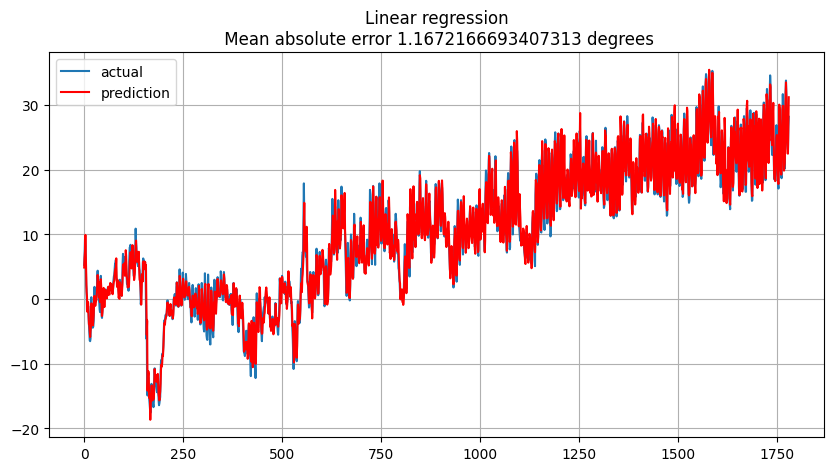

In [395]:
X_train, X_test, y_train, y_test = data.iloc[:37_000].drop('T', axis=1), data.iloc[37_000:].drop('T', axis=1), \
                                    data.iloc[:37_000]['T'], data.iloc[37_000:]['T']

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="actual")
plt.plot(y_pred, "r", label="prediction")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(y_pred, y_test)} degrees")

Ну вроде бы что-то получилось) Предскажим текущую погоду

In [396]:
current_data = pd.DataFrame(data.iloc[-1]).T.drop('T', axis=1) # показатели на 12 часов
pred_temp = lr.predict(current_data)
pred_temp[0]

31.22027526388149

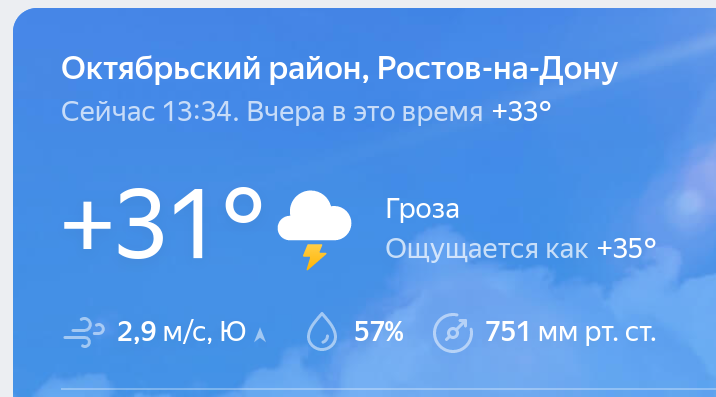

Наверное улучшило бы показатели, если бы я еще применил scaler, но меня и так вроде бы устраивает)